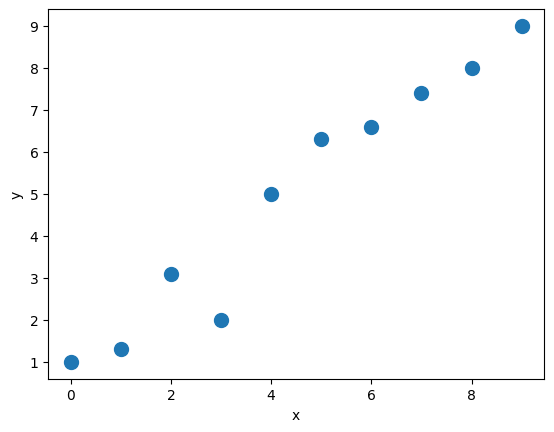

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([
    1.0, 1.3, 3.1, 2.0, 5.0,
    6.3, 6.6,7.4, 8.0, 9.0],
    dtype='float32'
)

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train).float()
train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [4]:
# manual way

torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad=True)

def model(xb):
    return xb @ weight + bias

def loss_fn(input, target):
    return (input-target).pow(2).mean()

In [5]:
learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        weight.grad.zero_()
        bias.grad.zero_()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch} Loss {loss.item():.4f}')

Epoch 0 Loss 41.2725
Epoch 10 Loss 24.4285
Epoch 20 Loss 1.0575
Epoch 30 Loss 15.1630
Epoch 40 Loss 12.5989
Epoch 50 Loss 5.0840
Epoch 60 Loss 0.7865
Epoch 70 Loss 3.7489
Epoch 80 Loss 2.4036
Epoch 90 Loss 0.4430
Epoch 100 Loss 1.1155
Epoch 110 Loss 1.3195
Epoch 120 Loss 0.1064
Epoch 130 Loss 0.5676
Epoch 140 Loss 0.2216
Epoch 150 Loss 1.4862
Epoch 160 Loss 0.0483
Epoch 170 Loss 0.0061
Epoch 180 Loss 0.0016
Epoch 190 Loss 0.0294


Final Parameters: 2.645277738571167 4.715577602386475


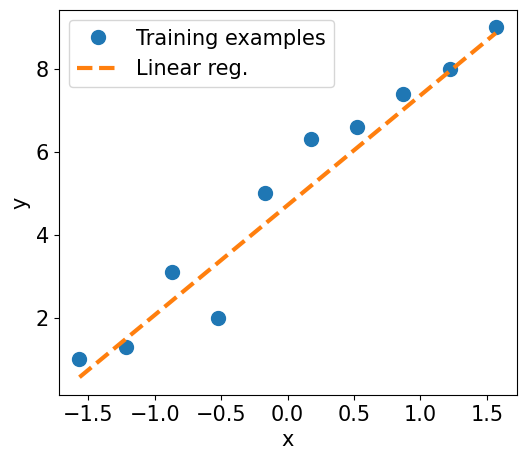

In [6]:
print('Final Parameters:', weight.item(), bias.item())

X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [7]:
# half-manual way

import torch.nn as nn

loss_fn = nn.MSELoss(reduction='mean')
input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch} Loss {loss.item():.4f}')

Epoch 0 Loss 24.6684
Epoch 10 Loss 29.1377
Epoch 20 Loss 20.9207
Epoch 30 Loss 0.1257
Epoch 40 Loss 12.4922
Epoch 50 Loss 1.7845
Epoch 60 Loss 7.6425
Epoch 70 Loss 2.5606
Epoch 80 Loss 0.0157
Epoch 90 Loss 0.7548
Epoch 100 Loss 0.8412
Epoch 110 Loss 0.4923
Epoch 120 Loss 0.0823
Epoch 130 Loss 0.0794
Epoch 140 Loss 0.0891
Epoch 150 Loss 0.0973
Epoch 160 Loss 0.1043
Epoch 170 Loss 0.1103
Epoch 180 Loss 0.0009
Epoch 190 Loss 0.0764


In [9]:
print('Final Parameters:', model.weight.item(), model.bias.item())

Final Parameters: 2.6496422290802 4.87706995010376


In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1./3,
    random_state=1
)

In [11]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [12]:
# nn.Module to build a model efficiently

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

In [13]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

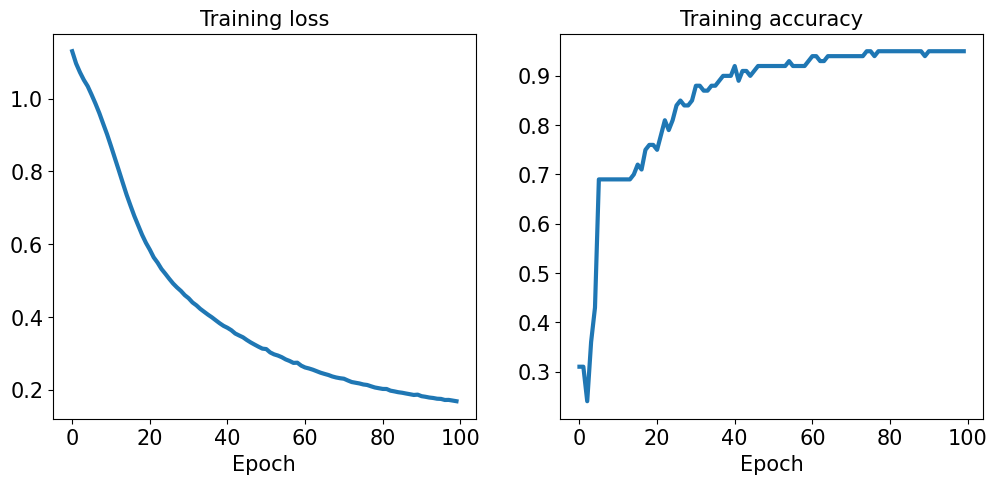

In [14]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [15]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [16]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [17]:
model_new = torch.load(path)
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [18]:
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [19]:
# save only params
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [20]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

In [4]:
import numpy as np

X = np.array([1, 1.4, 2.5])
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

In [5]:
print(f'P(y=1|x) = {logistic_activation(X, w):.3f}')

P(y=1|x) = 0.888


In [6]:
W = np.array([
    [1.1, 1.2, 0.8, 0.4],
    [0.2, 0.4, 1.0, 0.2],
    [0.6, 1.5, 1.2, 0.7]
])

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)

print('Net Input: \n', Z)
print('Output Units:\n', y_probas)

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [7]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label:', y_class)

Predicted class label: 0


In [8]:
# softmax

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)

print('Probabilities:\n', y_probas)
np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [10]:
import torch

torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

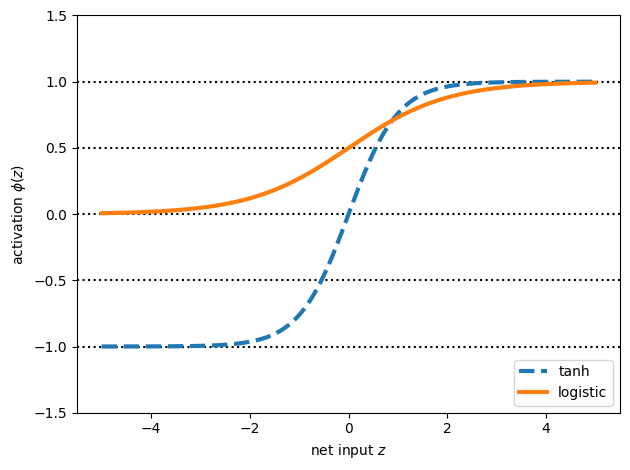

In [13]:
# hyperbolic tangent

import matplotlib.pyplot as plt


def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)


z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(
    z, tanh_act,
    linewidth=3,
    linestyle='--',
    label='tanh'
)
plt.plot(
    z, log_act,
    linewidth=3,
    label='logistic'
)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [15]:
print(np.tanh(z))
print(torch.tanh(torch.from_numpy(z)))

from scipy.special import expit
print(expit(z))
print(torch.sigmoid(torch.from_numpy(z)))

[-0.9999092  -0.99990829 -0.99990737 ...  0.99990644  0.99990737
  0.99990829]
tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)
[0.00669285 0.00672617 0.00675966 ... 0.99320669 0.99324034 0.99327383]
tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)


In [16]:
# ReLU

torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)